# COMP3314-Assignment 3 Kaggle Challenge

Note: Download the dataset from kaggle for the below code to work and place it in the same directory.

In [1]:
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import os
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import exposure
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from skimage.feature import local_binary_pattern
from sklearn.feature_selection import SelectKBest, f_classif
import cv2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
def read_image(path: str):
    return Image.open(path)

# 1. Dataset Analysis

### Basic Dataset Analysis

In [4]:
print(f"Total number of training data: {len(df)}")

sample_img_path = os.path.join('data/train_ims', df.iloc[0]['im_name'])
sample_img = read_image(sample_img_path)
sample_img.size
print(f"Image dimension: {sample_img.size}")

Total number of training data: 50000
Image dimension: (32, 32)


### Statistics on the number of categories

In [5]:
# Total number of unique categories
num_categories = df['label'].nunique()
print(f"Number of unique categories: {num_categories}")

Number of unique categories: 10


In [6]:
# Number of images per category
print("Number of images per category")
df['label'].value_counts().sort_index()

Number of images per category


label
0    5010
1    5012
2    5038
3    5007
4    4995
5    4993
6    4955
7    5000
8    5020
9    4970
Name: count, dtype: int64

### Visualization of example per category

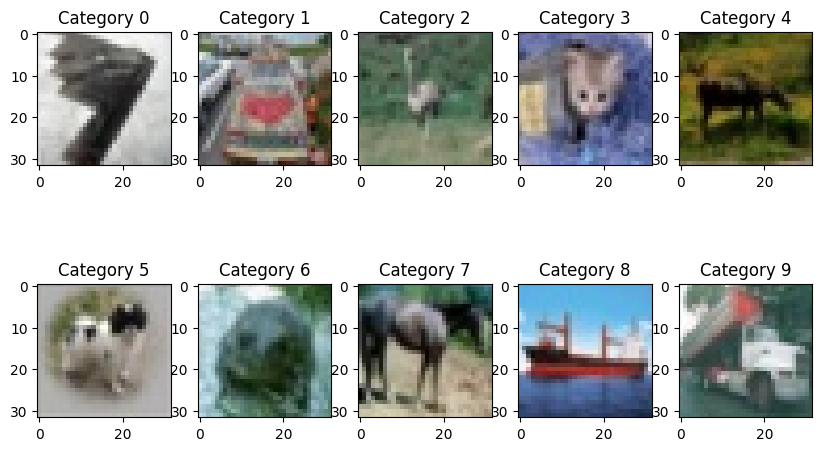

In [7]:
example_per_category = df.groupby('label').first().reset_index()
num_categories = example_per_category.shape[0]

fig, axes = plt.subplots(2, 5, figsize=(10, 6))

for idx, (i, row) in enumerate(example_per_category.iterrows()):
    row_idx = idx // 5
    col_idx = idx % 5
    ax = axes[row_idx, col_idx]

    img = read_image(os.path.join('data', 'train_ims', row['im_name']))
    ax.imshow(img)
    ax.set_title(f"Category {row['label']}")

# 2. Preprocessing

### Apply HOG (Histogram of Oriented Gradients) Feature Descriptor

In [8]:
def extract_features(image):
    # Convert to gray scale
    img = rgb2gray(image)

    # Resize to image to fit the HOG window size
    img = cv2.resize((img * 255).astype('uint8'), (64, 64))

    # HOG parameters
    win_size = (64, 64)
    block_size = (32, 32)
    block_stride = (16, 16)
    cell_size = (8, 8)
    nbins = 12

    hog = cv2.HOGDescriptor(
        win_size, block_size, block_stride, cell_size, nbins
    )

    # Compute and flatten to a vector
    return hog.compute(img).flatten()

### Extract the features from each training image and store into X, y

In [9]:
# Features Extractions
features_list = []
labels = []
IMG_DIR = 'data/train_ims'

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    img_path = os.path.join(IMG_DIR, row['im_name'])
    img = imread(img_path)

    features = extract_features(img)
    features_list.append(features)
    labels.append(row['label'])

X = np.array(features_list)
y = np.array(labels)

100%|██████████| 50000/50000 [00:25<00:00, 1924.75it/s]


### Use FULL training set for test set submission

In [10]:
X_train, X_val, y_train, y_val = X, X, y, y # X_val, y_val are NOT used (dummy values)

### Apply PCA for dimensionality reduction for faster training and capturing important vectors

In [11]:
# PCA
TARGET_DIMENSION = 512
pca = PCA(n_components=TARGET_DIMENSION)
X_train = pca.fit_transform(X_train)

# 3. Parameter tuning and model selection

We will utilize 10% of the full dataset to tune the parameters on SVM and KNN for modal comparison. Reduced dataset size allows to increase the speed for tuning and the parameters obtained can be utilized for the full dataset. Since parameter tuning and model selection is mainly concerned with relative performance, so a reduced dataset should be enough.


#### Data Split for Tuning and Model Selection

In [12]:
# Reducing the dataset to 10% (~ 5000 images)
X_tuning, y_tuning = X_train[:int(len(X_train)*0.1)], y_train[:int(len(y_train) * 0.1)]

# Splitting the dataset for parameter tuning
X_train_tuning, X_val_tuning, y_train_tuning, y_val_tuning = train_test_split(X_tuning, y_tuning, test_size=0.2, stratify=y_tuning, random_state=42)


#### Parameter Tuning with KNN

In [13]:
# Parameter tuning for KNN
for nei in [5, 10, 15, 30, 50, 75, 100, 150, 200]:
    knn_tune = KNeighborsClassifier(n_neighbors=nei)
    knn_tune.fit(X_train_tuning, y_train_tuning)
    y_pred_tuning = knn_tune.predict(X_val_tuning)
    accuracy_tuning = accuracy_score(y_val_tuning, y_pred_tuning)
    print(f'KNN (n_neighbors = {nei:>3})   Validation accuracy: {accuracy_tuning*100:.2f}%')

KNN (n_neighbors =   5)   Validation accuracy: 46.30%
KNN (n_neighbors =  10)   Validation accuracy: 46.90%
KNN (n_neighbors =  15)   Validation accuracy: 47.40%
KNN (n_neighbors =  30)   Validation accuracy: 46.60%
KNN (n_neighbors =  50)   Validation accuracy: 44.50%
KNN (n_neighbors =  75)   Validation accuracy: 41.90%
KNN (n_neighbors = 100)   Validation accuracy: 41.20%
KNN (n_neighbors = 150)   Validation accuracy: 40.50%
KNN (n_neighbors = 200)   Validation accuracy: 38.80%


#### Parameter tuning for SVM

In [14]:
# We perform grid search for parameter-tuning on SVM
param_grid = {
    'C': [8, 12, 14, 16],
    'gamma': ['scale'],
    'kernel': ['linear', 'rbf']
}

svc_tuning = SVC()
grid_search = GridSearchCV(estimator=svc_tuning, param_grid=param_grid, cv=5)
grid_search.fit(X_train_tuning, y_train_tuning)

# Best Parameters
best_params_svc = grid_search.best_params_
# Best estimator
best_model_svc  = grid_search.best_estimator_

# Best prediction accuracy
y_pred_svc_tuning           = best_model_svc.predict(X_val_tuning)
accuracy_best_svc_tuning    = accuracy_score(y_pred_svc_tuning, y_val_tuning)

print(f"Best SVM accuracy: {accuracy_best_svc_tuning*100:.2f}%")
print(f"Best Hyperparameters: {best_params_svc}")

Best SVM accuracy: 59.40%
Best Hyperparameters: {'C': 8, 'gamma': 'scale', 'kernel': 'rbf'}


#### Comparison analysis between SVM and KNN

SVM has better accuracy for the small dataset relative to KNN and therefore, we choose SVM as the model to train the whole dataset.

# 4. Training with Full Dataset

### Train with SVM (rbf kernel)

In [15]:
# SVM
clf = SVC(kernel='rbf', C=8, gamma='scale', random_state=42)
clf.fit(X_train, y_train)

SVC(C=8, random_state=42)

### Train with KNN

In [16]:
knn_clf = KNeighborsClassifier(n_neighbors=15)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

### Apply the same feature extraction and PCA for test dataset.

In [17]:
test_df = pd.read_csv("data/test.csv")
test_image_names = test_df['im_name'].tolist()

TEST_IMAGE_DIR = 'data/test_ims'
X_test = []
for img_name in tqdm(test_image_names):
    img_path = os.path.join(TEST_IMAGE_DIR, img_name)
    img = imread(img_path)
    features = extract_features(img)
    X_test.append(features)

X_test = np.array(X_test)

# Apply PCA
X_test = pca.transform(X_test)

100%|██████████| 10000/10000 [00:07<00:00, 1253.83it/s]


### Test set prediction

In [18]:
y_test_pred = clf.predict(X_test)

### Convert to csv file for submission

In [ ]:
submission_df = pd.DataFrame({
    'im_name': test_image_names,
    'label': y_test_pred
})

# Save to CSV
submission_df.to_csv('submission_hog_opencv_full.csv', index=False)